In [28]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
from skimage import img_as_int
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching as ast
from imp import reload
from alpenglow.stitching import stitch, find_shift, apply_shift

In [29]:
from skimage.feature import register_translation
from skimage import img_as_float
from skimage import exposure
from skimage.io import imread_collection, ImageCollection
from skimage.external.tifffile import imread
import skimage.external.tifffile as tif
import skimage
import dask.array as da
from dask import delayed
import glob as globby

In [30]:
import configparser
import os.path as op
import cottoncandy as cc
from io import BytesIO
import tempfile

In [6]:
imread = delayed(skimage.io.imread, pure=True)  # Lazy version of imread
filenames = []
for x in range(1, 513):
    fname = "%06d_%05d.tif" % (1, x)
    filenames.append('../data/phantom_2_7_2017/000001/' + fname)

lazy_values = [imread(filename) for filename in filenames]    
sample = skimage.io.imread(filenames[100])
arrays = [da.from_delayed(lazy_value,           # Construct a small Dask array
                          dtype=sample.dtype,   # for every lazy value
                          shape=sample.shape)
          for lazy_value in lazy_values]

stack = da.stack(arrays, axis=0)  

for z in range(1,stack.shape[1]):
    filename = 'zstack_000001_%05d.tif' % z 
    tiff.imsave(filename, stack[:,z,:].compute())
zstack = ImageCollection('zstack_000001_*.tif')
return zstack

SyntaxError: 'return' outside function (<ipython-input-6-887c750fc55f>, line 20)

In [10]:
len(zstack)

511

In [11]:
z_array = skimage.io.concatenate_images(zstack)

In [12]:
z_array.shape

(511, 512, 900)

In [14]:
subset_z = z_array[100:200, 100:200, 300:600]

In [13]:
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.tools import FigureFactory as FF
import plotly
plotly.offline.init_notebook_mode(connected=True)
import numpy as np
from skimage import measure


In [7]:
plotly.tools.set_credentials_file(username='nicholasreder', api_key='CDcvK7IZTJKLjQILnxzn')

In [60]:
# start with plotly demo
X,Y,Z = np.mgrid[-2:2:40j, -2:2:40j, -2:2:40j]
surf_eq = X**4 + Y**4 + Z**4 - (X**2+Y**2+Z**2)**2 + 3*(X**2+Y**2+Z**2) - 3  

In [61]:
vertices, simplices = measure.marching_cubes(surf_eq, 0)
x,y,z = zip(*vertices) 

In [62]:
colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
fig = plotly.figure_factory.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=simplices,
                        title="Isosurface")
plotly.offline.iplot(fig)

In [15]:
vertices, simplices = measure.marching_cubes(subset_z, level=100)
x,y,z = zip(*vertices) 

In [16]:
simplices

array([[  2,   1,   0],
       [  3,   1,   2],
       [  0,   1,   4],
       ..., 
       [408, 411, 409],
       [412, 408, 410],
       [412, 411, 408]])

In [45]:
colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
fig = plotly.figure_factory.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=simplices,
                        title="Isosurface")
py.iplot(fig)

PlotlyRequestError: No Content

### Trying with scikit image

In [17]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from skimage.draw import ellipsoid

In [8]:
# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)

In [10]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(ellip_double, 0)

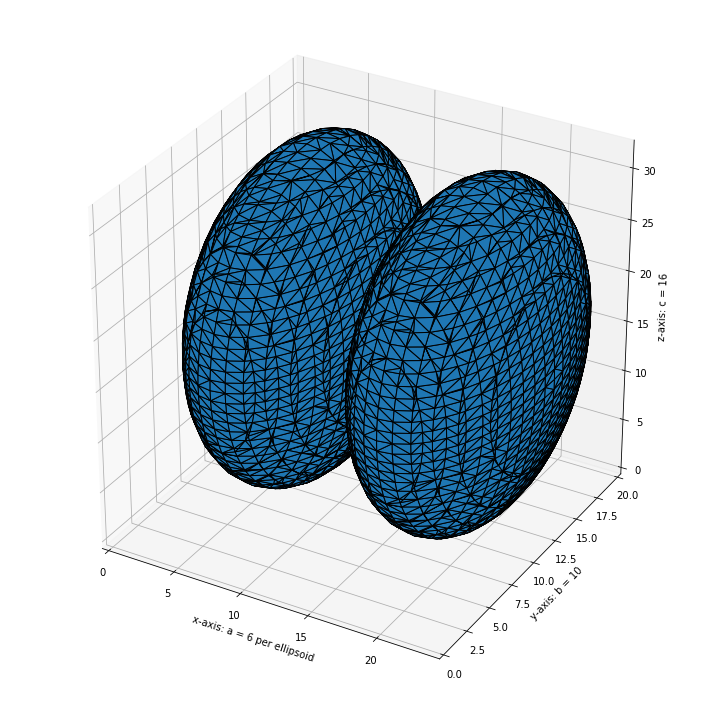

In [13]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

### Now try with my data

In [18]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(subset_z, 200)

In [ ]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 75)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 175)  # b = 10
ax.set_zlim(0, 75)  # c = 16

plt.tight_layout()
plt.show()

In [40]:
np.max(subset_z)

13341

In [19]:
inverse_array = np.max(subset_z) - subset_z

In [20]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(inverse_array, 10000)

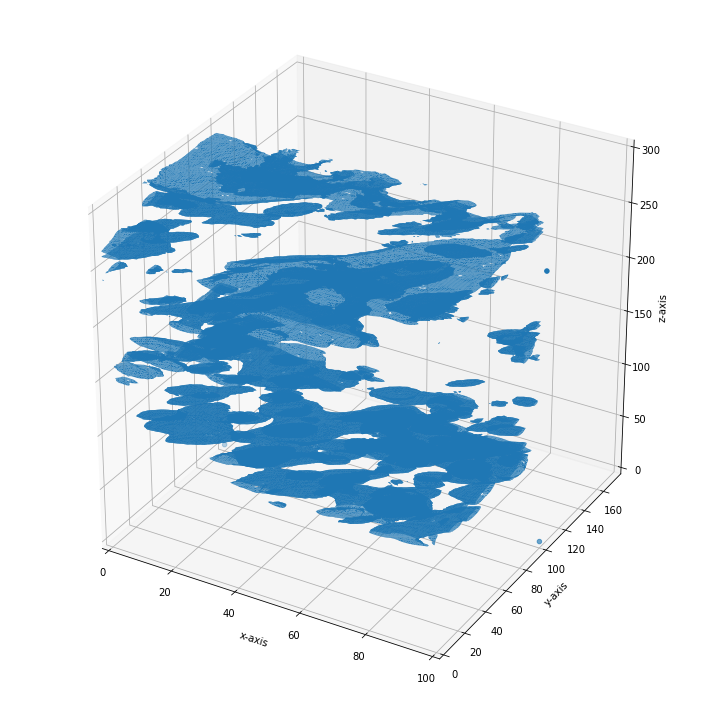

In [27]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('None')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

ax.set_xlim(0, 100)  
ax.set_ylim(0, 175)  
ax.set_zlim(0, 300)  

x = [0, 0, 100, 100]
y = [100, 100, 100, 100]
z = [0, 250, 250, 0]
ax.scatter(x,y,z)

plt.tight_layout()
plt.show()

Cool, that actually worked

[0, 10, 0, 10]

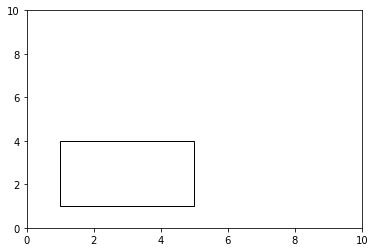

In [24]:
from pylab import *
from matplotlib.patches import Rectangle
ax = gca()
p = Rectangle((1,1),4,3,fill=False)
ax.add_patch(p)
axis([0,10,0,10])

### Trying to segment glands

In [54]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


In [58]:
img = inverse_array

labels1 = segmentation.slic(img, compactness=30, n_segments=400)

In [59]:
labels1

array([[  0,   0,   0, ...,  19,  19,  19],
       [  0,   0,   0, ...,  19,  19,  19],
       [  0,   0,   0, ...,  19,  19,  19],
       ..., 
       [380, 380, 380, ..., 399, 399, 399],
       [380, 380, 380, ..., 399, 399, 399],
       [380, 380, 380, ..., 399, 399, 399]])

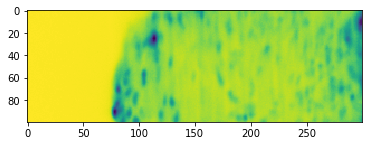

In [78]:
plt.imshow(inverse_array[:,75,:])

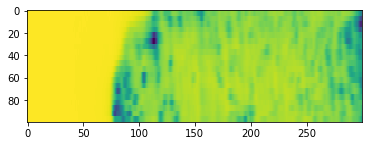

In [79]:
out1 = color.label2rgb(labels1, img, kind='avg')
plt.imshow(out1[:,75,:])

In [61]:
g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 29)
out2 = color.label2rgb(labels2, img, kind='avg')

ValueError: operands could not be broadcast together with shapes (3,) (300,) (3,) 

In [ ]:
img = data.coffee()

labels1 = segmentation.slic(img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 29)
out2 = color.label2rgb(labels2, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True,
                       figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

### Playing with Plotly

In [32]:
data = go.Data([
    go.Mesh3d(
        x = [0, 1, 2, 0],
        y = [0, 0, 1, 2],
        z = [0, 2, 0, 1],
        colorbar = go.ColorBar(
            title='z'
        ),
        colorscale = [['0', 'rgb(255, 0, 0)'], ['0.5', 'rgb(0, 255, 0)'], ['1', 'rgb(0, 0, 255)']],
        intensity = [0, 0.33, 0.66, 1],
        i = [0, 0, 0, 1],
        j = [1, 2, 3, 2],
        k = [2, 3, 1, 3],
        name = 'y',
        showscale = True
    )
])
layout = go.Layout(
    xaxis=go.XAxis(
        title='x'
    ),
    yaxis=go.YAxis(
        title='y'
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-mesh-tetrahedron-python')

In [33]:
go.Mesh3d?